Just to start with, lets have all our imports

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import gumps.kernels.ackley_complete_kernel
import gumps.kernels
import numpy as np

import random

#this is to make the tests predictable, DO NOT REMOVE
random.seed(0)
np.random.seed(0)

from gumps.studies.batch_study import AbstractBatchStudy
from gumps.common.parallel import Parallel
import pandas as pd
from typing import Callable
import attrs

import scipy
import gumps.studies.ackley_batch_study
import gumps.solvers.monte_carlo_solver
import gumps.apps.monte_carlo
import seaborn as sns

import gumps.solvers.sampler
import gumps.apps.parametric_sweep

from gumps.solvers.regressors.gaussian_regressor import GaussianRegressor
from gumps.solvers.regressors.regression_solver import RegressionParameters
from gumps.studies import SimpleSimulationStudy, SimulationStudy
from gumps.graph.regressor import RegressorPlotParameters, RegressorPlot
from gumps.apps.adaptive_sampler import AdaptiveSamplerApp, AdaptiveSamplerAppParameters
from gumps.solvers.adaptive_solver import AdaptiveSamplerParameters
from pymoo.problems import get_problem
from pymoo.visualization.fitness_landscape import FitnessLandscape

%matplotlib inline

![](./img/gumps_logo.PNG)

## or... How I Learned to Stop Worrying and Love Python

## What is GUMPS?

* Generic Universal Modeling Platform Software
* Re-Envision Complex Models as smaller modules and their interfaces
    * Reduces Code Duplication
    * Speeds Up Development


## Kernel
A Basic Unit of Computation, to create one we need to define three things:

1) get_states  

Defines all of the variables needed for computation.

2) initialize  

A location to create "expensive" objects needed for computation, (loading a neural network)

3) user_defined_function  

Computation code for a single "step", takes a variable registry(attr dataclass) as an argument

In this tutorial, we are going to use the Ackley function. This is how it looks.

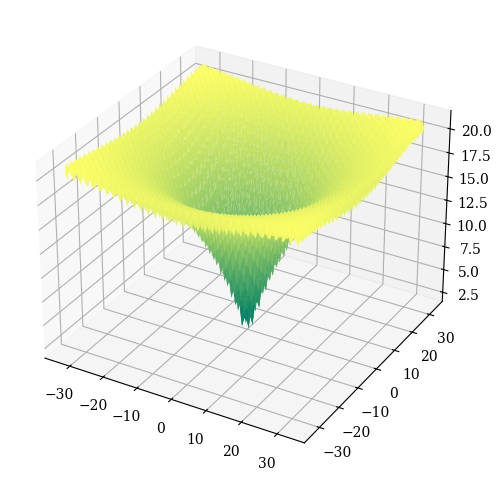

In [2]:

problem = get_problem("ackley", n_var=2, a=20, b=0.1, c=2 * np.pi)

FitnessLandscape(problem, n_samples=100, _type="surface").show()

Lets convert the above ackley function into a kernel

Let's create a Kernel (Class) named AckleyCompleteKernel which inherits from the AbstractKernel class.

Add the computation for the ackley in the user_defined_function() method

Add the required variables are defined in a dataclass and the get_state_class() returns this object.

In [3]:
@attrs.define
class AckleyCompleteState:
    "states for the AckleyCompleteKernel"
    a: float
    b: float
    c: float
    x: np.ndarray = attrs.field(converter=np.array)
    term1: float = 0.0
    term2: float = 0.0
    total: float = 0.0


class AckleyCompleteKernel(gumps.kernels.kernel.AbstractKernel):
    'Ackley Kernel'
    
    def initialize(self):
        "initialize expensive objects, none to initialize here"

    def user_defined_function(self, variables: AckleyCompleteState) -> None:
        "compute the function"
        sum_squared = np.sum(variables.x**2)
        variables.term1 = (-variables.a) * np.exp( - variables.b * np.sqrt(sum_squared/len(variables.x)))
        mean = np.mean(np.cos(variables.c*variables.x))
        variables.term2 = - np.exp(mean)
        variables.total = variables.term1 + variables.term2 + variables.a + np.exp(1)

    def get_state_class(self) -> AckleyCompleteState:
        "return the state class"
        return AckleyCompleteState

ackley_kernel =  AckleyCompleteKernel()

#Inspect its allowable states:
print(ackley_kernel.allowed_state)

{'x', 'c', 'a', 'term1', 'term2', 'total', 'b'}


## Study

A study connects a kernel to a solver. It allows running the kernel. 

We add the parameters required for the computation of the kernel in a dict variable called the problem

Let's create a study using the SimpleSimulationStudy class. This study has a built in solver which calls the kernel and returns the results.

In [4]:
problem = {'x' : np.array([1,2]),'a' : 1,'b' : 2 ,'c' : 1}
study = SimpleSimulationStudy(problem, ackley_kernel)
result = study.run()
print(result)
print('********')
print(study.state_frame())

AckleyCompleteState(a=1, b=2, c=1, x=array([1, 2]), term1=-0.04232921962320499, term2=-1.0640450546943585, total=2.6119075541414816)
********
   a  b  c       x     term1     term2     total
0  1  2  1  [1, 2] -0.042329 -1.064045  2.611908


# Creating a Batch Study

GUMPS is built based on interfaces. Most of the higher order operations are built on top of the batch interface. Operations such as uncertainty quantification, sensitivity analysis, and optimization are all built on top of the batch interface.

Create a class named BatchStudyMultiProcess with the following required methods:
1. init() - Takes the study object and the pool processing object
2. start() - Initilializes the tasks needed for parallel processing
3. stop() - Shutdowns the tasks
4. run() - Runs the batch simulation


In [5]:
class BatchStudyMultiProcess(AbstractBatchStudy):
    "create a batch study by using a SimulationStudy and pool processing"

    def __init__(self, *, study:SimulationStudy, parallel:Parallel):
        "create a simulation study with a parallel pool"
        self.study = study
        self.parallel = parallel

    def start(self):
        "handle any initialization tasks that are needed"
        self.parallel.start()

    def stop(self):
        "handle any shutdown tasks that are needed"
        self.parallel.stop()

    def run(self, input_data: pd.DataFrame, processing_function:Callable) -> pd.DataFrame:
        "run the batch simulation"
        rows = (row.to_dict() for idx,row in input_data.iterrows())
        results = list(self.parallel.runner(self.study.run_data, rows))
        self.save_results(input_data, results)

        return pd.DataFrame(processing_function(result) for result in results)


The above Batch study will be used to run the ackley study in a parallel processing pool.
- We will initialize the BatchStudyMultiProcess with the ackley study and a parallel parameter with a pool size for faster execution.
- Now lets's create a input_data dataframe with the states variables added as keys (columns) and multiarray data as values
- Define a method that will be the processing function for the input dataframe

In [6]:
parallel = Parallel(poolsize=1) #blame jupyter!
batch = BatchStudyMultiProcess(study=study, parallel=parallel)

input_data = pd.DataFrame({'x': [np.array([1,2,3,4]),np.array([1,2,3,4]),np.array([1,2,3,4])],
                            'a' : [1,2,3],
                            'b' : [1,2,3],
                            'c' : [1,2,3],
            })


#Specify what we want!
def get_total(frame:pd.DataFrame):
    return {'total': frame.total[0]}

with batch:
    totals = batch.run(input_data, get_total)
print(totals)

      total
0  2.969672
1  3.771709
2  4.741453


The processing function can do anything with the variables passed OR available after the computation in the dataframe as shown below.

In [7]:
def get_whatever(frame: pd.DataFrame):
    return {'a': frame.a[0], 'a_squared' : frame.a[0]**2}

with batch:
    totals = batch.run(input_data, get_whatever)

print(totals)

   a  a_squared
0  1          1
1  2          4
2  3          9


Lets create a UQ app with the Ackley Batch Study which requires the following variables:
1. distributions : A dictionary of scipy distributions
2. parameters : MonteCarloParameters object with initialization values
3. model_variables : These are the variables needed to setup the model
4. columns : The key used in the distributions dict

- Now Create a Ackley batch study and create an app using the MonteCarloApp class.
- Define the processing and pre processing function before the data is accessed with the batch run


In [8]:
distributions = {"x1":scipy.stats.uniform(0.0, 1),
                "x2":scipy.stats.uniform(0.0, 1),
                "a":scipy.stats.uniform(10, 30),
                "b":scipy.stats.uniform(0.1, 0.5),
                "c":scipy.stats.uniform(np.pi, 5*(np.pi))
                }

parameters = gumps.solvers.monte_carlo_solver.MonteCarloParameters(variable_distributions=distributions,
                                                                target_probability=[0.45],
                                                                window=3,
                                                                tolerance=1e-1,
                                                                min_steps=3,
                                                                sampler_seed=0,
                                                                sampler_scramble=False)

model_variables = {}


batch = gumps.studies.ackley_batch_study.AckleyBatchStudy(model_variables=model_variables)

def pre_processing_function(input_data: pd.DataFrame):
    "pre-process the data"
    input_data_processed = {}
    input_data_processed['x'] = list(np.column_stack([input_data.x1, input_data.x2]))
    input_data_processed['a'] = input_data.a
    input_data_processed['b'] = input_data.b
    input_data_processed['c'] = input_data.c

    return pd.DataFrame(input_data_processed)

def processing_function(frame: pd.DataFrame):
    "process the dataframe for the ackley function"
    return pd.DataFrame(frame['total'])

app = gumps.apps.monte_carlo.MonteCarloApp(parameters=parameters,
    processing_function=processing_function,
    pre_processing_function=pre_processing_function,
    directory=None,
    batch=batch)
app.run()


answer = app.answer().to_numpy()
print(answer)


[4.89582165]


Create a plot to view the results

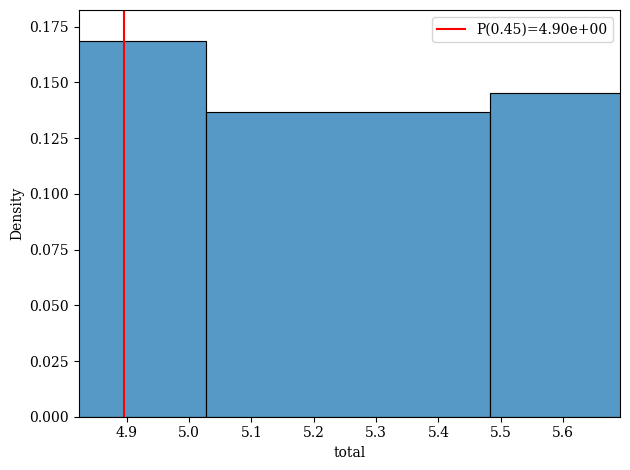

<Figure size 640x480 with 0 Axes>

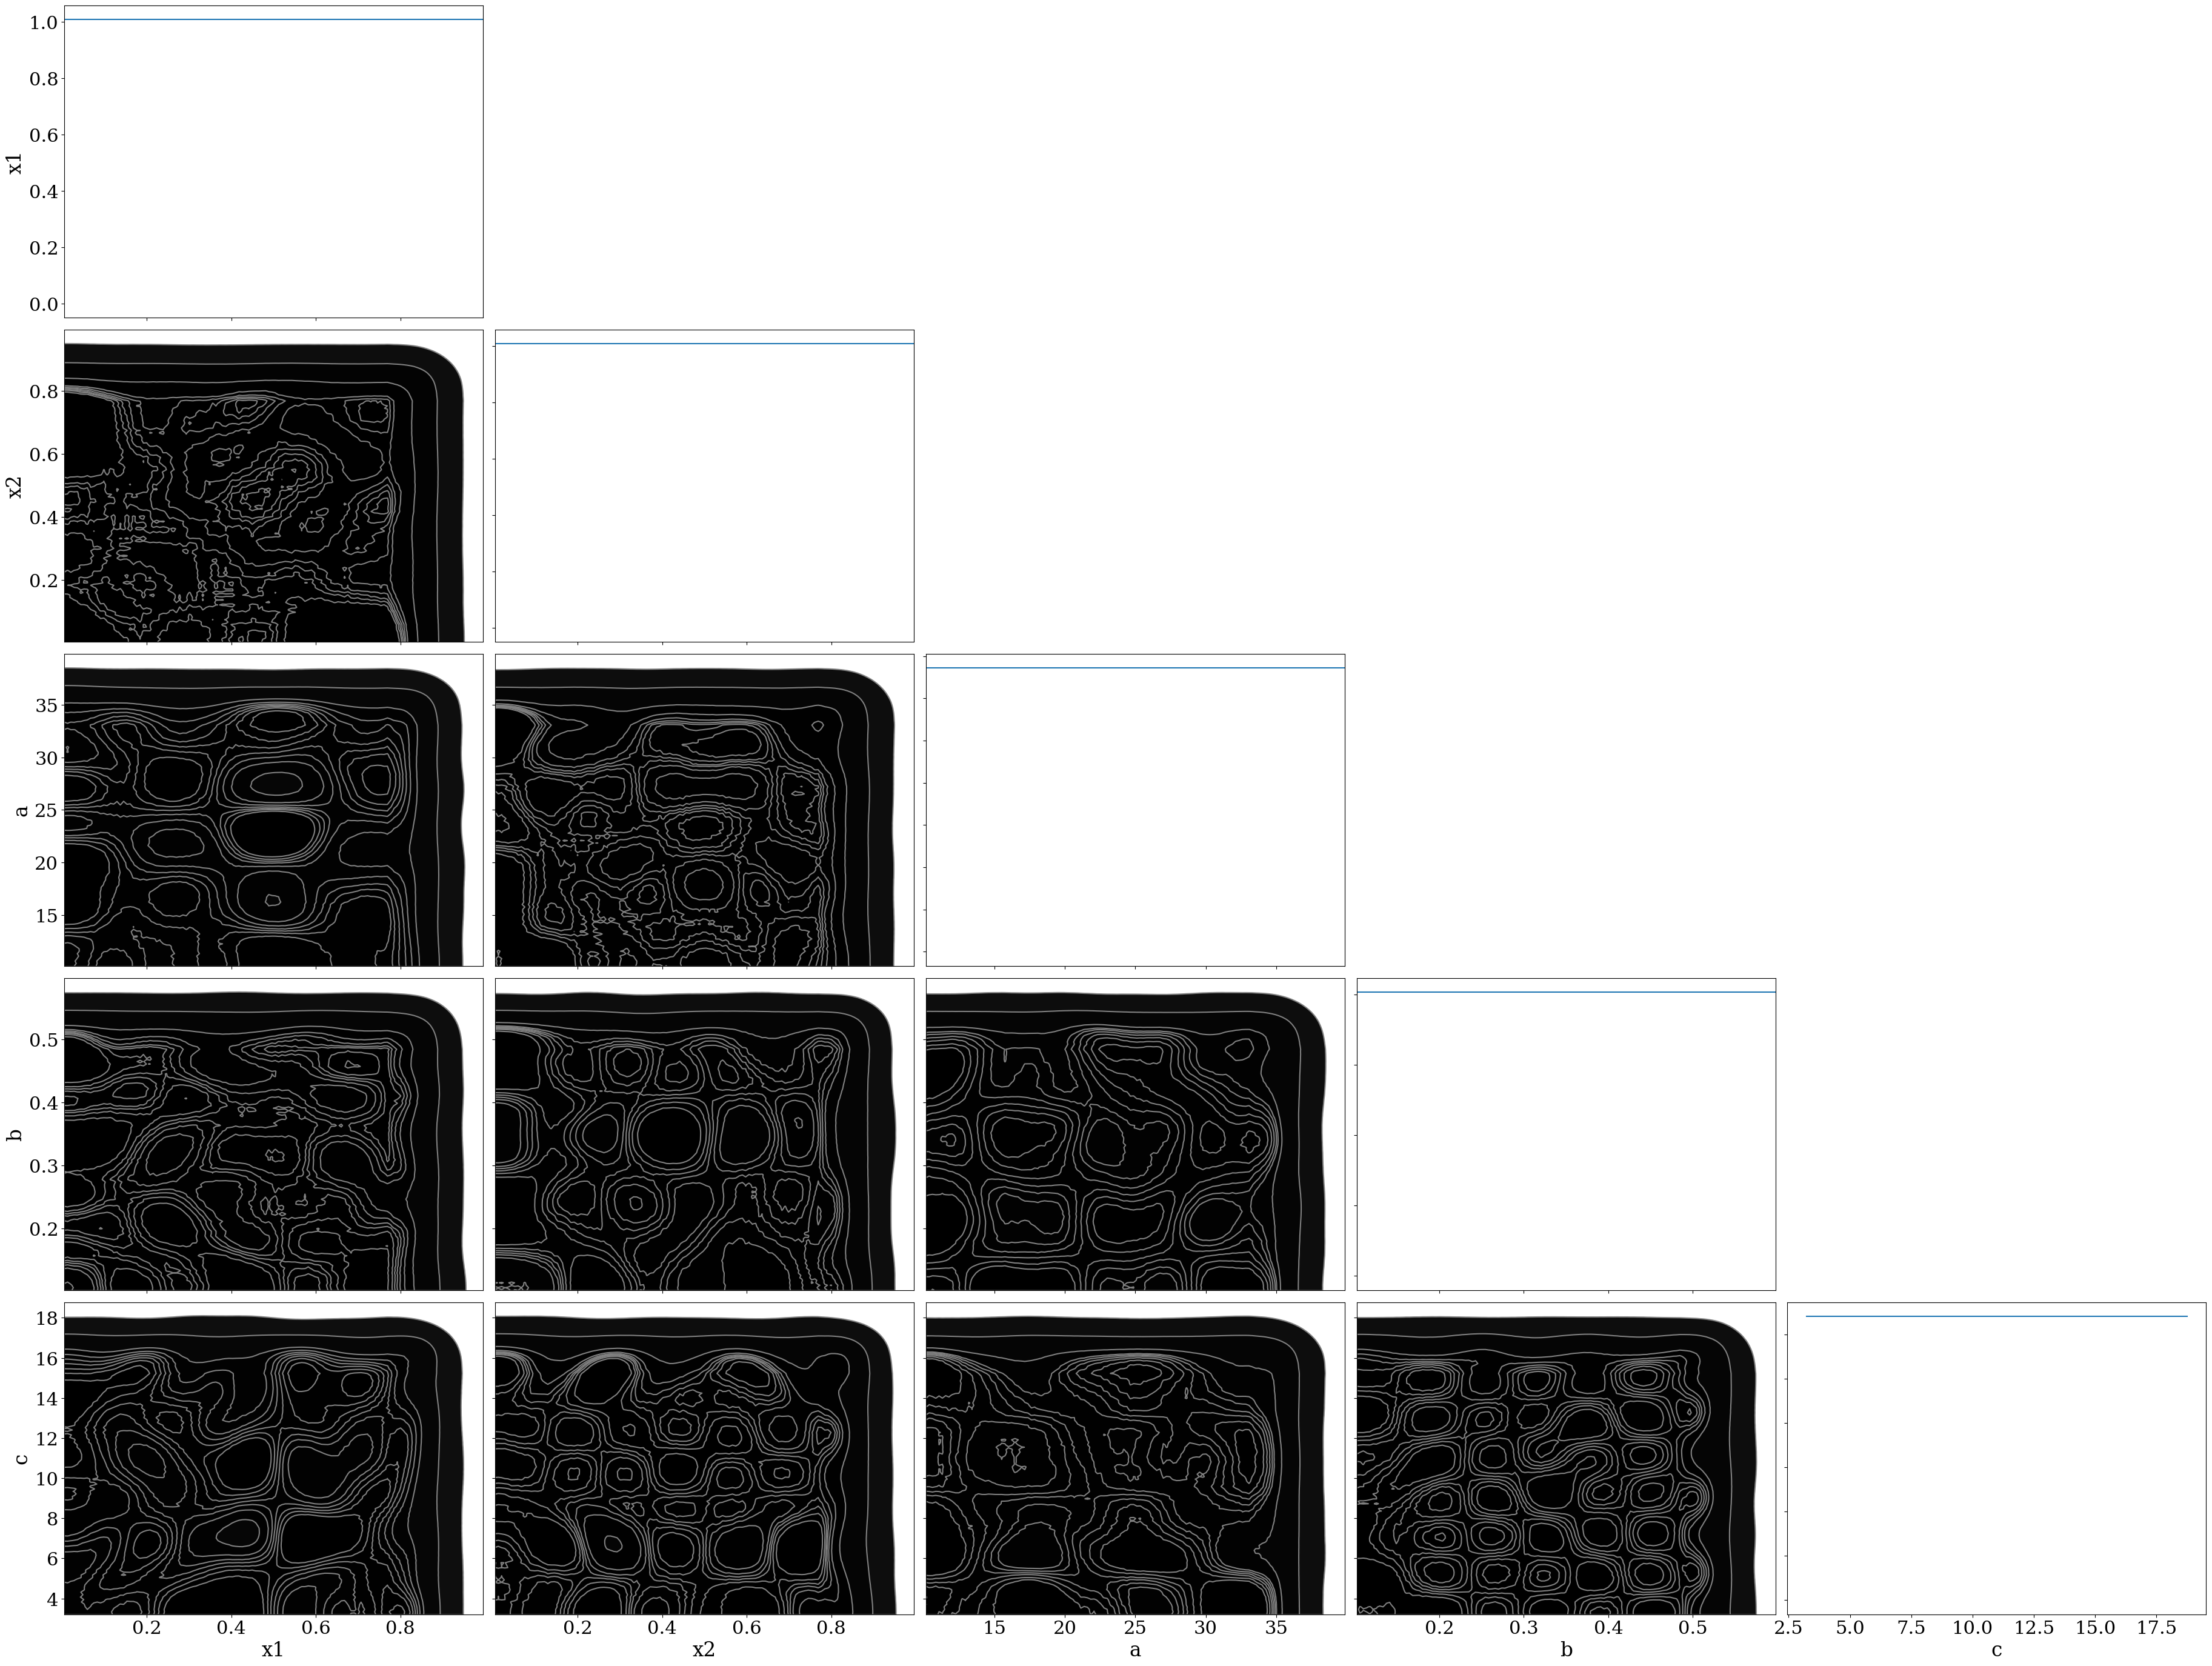

In [9]:
app.create_plots()

Lets create a parametric sweep app
- Create the parameters using the SamaplerSolverParameters
    - Add the number of samples to be created
    - Lower bound and Upper bound for each state varaibles
    - Sampler type 
- Create the App
- Run the app

In [10]:

parameters = gumps.solvers.sampler.SamplerSolverParameters(
    number_of_samples = 128,
    lower_bound = {'x1':-32, 'x2':-32, 'a':19, 'b':0.05, 'c':np.pi},
    upper_bound = {'x1':32,  'x2':32, 'a':20, 'b':0.1, 'c':2*np.pi},
    sampler = "sobol"
    )

app = gumps.apps.parametric_sweep.ParametricSweepApp(parameters=parameters,
            processing_function=processing_function,
            pre_processing_function=pre_processing_function,
            directory=None,
            batch=batch)
app.run()
print(app.responses)

            total
0    1.516397e+01
1    4.440892e-16
2    1.216832e+01
3    1.487971e+01
4    1.270521e+01
..            ...
123  1.231181e+01
124  1.295627e+01
125  1.858706e+01
126  1.310998e+01
127  1.840917e+01

[128 rows x 1 columns]


Lets look at the facors and responses for the sampler

1. Let's look at the responses

<Axes: ylabel='Count'>

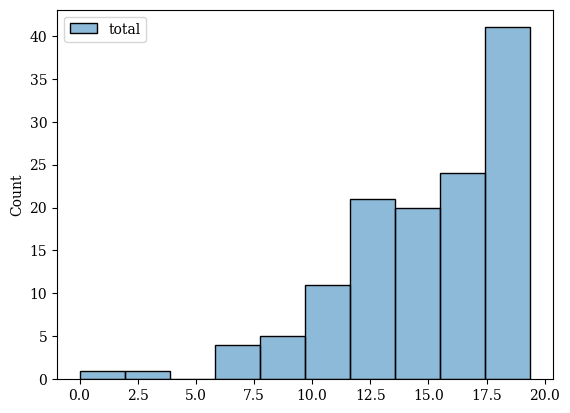

In [11]:
sns.histplot(app.responses)

2. Let's look at the factors

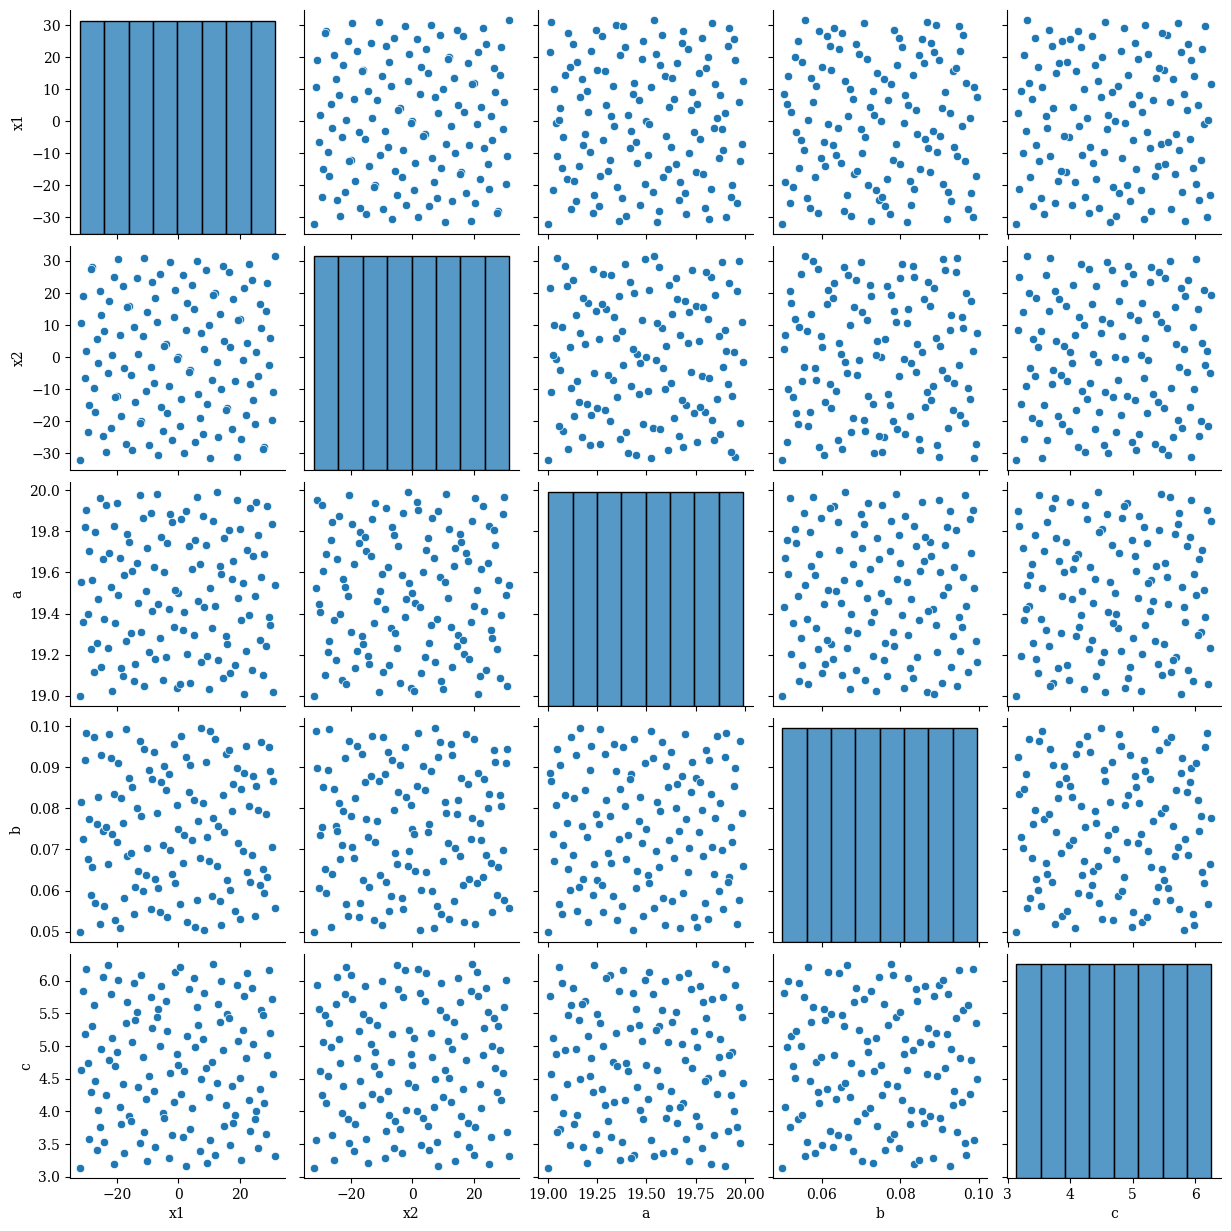

In [12]:
sns.pairplot(app.factors)

Next lets grab all the factors, responses.

In [13]:
factors = app.factors
responses = app.responses

Lets build a basic regression model using Gaussian Processes.
- Create the regression parameters objects using the RegressionParameters Class with input data being the factors and output data as responses
- Pass the regression parameters to the GaussianRegressor class to create a regressor 
- Fit the regressor using regressor object

In [14]:
regression_parameters = RegressionParameters(input_data=factors,
            output_data=responses)
regressor = GaussianRegressor(regression_parameters)
regressor.fit()

We can then look at how well the model fits the data.

The first step is to look at the error metrics. There are many metrics that are available. The r2 score is the default one used in scipy but it is not always appropriate. In most cases you should use the normalized_root_mean_squared_error and in this case it shows an error around 20%.

In [15]:
regressor.error_metrics()

score                                 -0.121379
r2_score                              -0.121379
mean_squared_error                    14.619331
mse                                   14.619331
root_mean_squared_error                3.823523
rmse                                   3.823523
normalized_mean_squared_error          0.038895
nmse                                   0.038895
normalized_root_mean_squared_error     0.197217
nrmse                                  0.197217
dtype: float64

The next step is to look at a response plot. In order to do that we need to choose a starting point and the bounds of the response plot.

For this we are going to use the mean value as the center of the response plot and the upper and lower bounds of the sampled region.

In [16]:
start = regression_parameters.input_data.mean()

lower_bound = regression_parameters.input_data.min()

upper_bound = regression_parameters.input_data.max()
params = RegressorPlotParameters(regressor, start, lower_bound, upper_bound)

Now lets look at the response plot.

In [17]:
reg_plot = RegressorPlot(params)
reg_plot.plot()

Let's use adaptive sampler
- Create sampler parameters using the AdaptiveSamplerParameters class
    - Pass the points_to_add, batch_size, max_iterations, population_size
- Create the Sampler App Parameters and pass the regressor and sampler_parameters

In [18]:

sampler_parameters = AdaptiveSamplerParameters(
    points_to_add=50,
    batch_size=10,
    max_iterations=100,
    population_size=100
)

parameters = AdaptiveSamplerAppParameters(
    regressor=regressor,
    sampler_parameters = sampler_parameters
    )

app = AdaptiveSamplerApp(parameters=parameters,
                            batch=batch,
                            processing_function=processing_function,
                            pre_processing_function=pre_processing_function)
app.run()

Lets visualize the regressor again and see how this worked, we can clearly see that the point are spread out around the space.

In [ ]:
params = RegressorPlotParameters(regressor, start, lower_bound, upper_bound)

reg_plot = RegressorPlot(params)
reg_plot.plot()